In [7]:
%cd /home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST

/home1/giorgian/projects/trigger-detection-pipeline/sPHENIX/trigger-detection/BGN-ST


In [8]:
import torch
import pickle
import dataloaders
import matplotlib.pyplot as plt
from utils.log import load_checkpoint
from collections import defaultdict
from itertools import islice
from tqdm.notebook import tqdm
from models.Bipartite_Attention_Masked import Bipartite_Attention as Model
import matplotlib as mpl
import torch.nn as nn
import numpy as np
import random

In [9]:
from importlib import reload

In [10]:
#config_file_path = 'train_results/biatt-augment-adj/experiment_2023-06-13_10:12:01/config.pkl'
config_file_path = 'train_results/biatt-interaction/experiment_2024-02-02_08:03:04/config.pkl'
with open(config_file_path, 'rb') as f:
    config = pickle.load(f)

In [11]:
dconfig = config['data']
dconfig['n_valid'] = 250000
train_data, val_data, test_data = dataloaders.get_data_loaders(**dconfig)


In [12]:
DEVICE = 'cuda:0'
# α=0.7
#checkpoint_file = 'train_results/biatt-augment-adj/experiment_2023-06-13_10:12:01/checkpoints/model_checkpoint_016.pth.tar'
checkpoint_file = 'train_results/biatt-interaction/experiment_2024-02-02_08:03:04/checkpoints/model_checkpoint_008.pth.tar'
mconfig = config['model']
model = Model(**mconfig)
model = load_checkpoint(checkpoint_file, model)
model = model.to(DEVICE)
model.eval()

Bipartite_Attention(
  (_layers): ModuleList(
    (0): Bipartite_Layers(
      (enc): ModuleList(
        (0): Masked_SAB(
          (mab): Masked_MAB(
            (fc_q): Linear(in_features=37, out_features=128, bias=True)
            (fc_k): Linear(in_features=37, out_features=128, bias=True)
            (fc_v): Linear(in_features=37, out_features=128, bias=True)
            (fc_o): Linear(in_features=128, out_features=128, bias=True)
            (ln0): Masked_LayerNorm(
              (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            )
            (ln1): Masked_LayerNorm(
              (ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            )
          )
        )
        (1): Masked_SAB(
          (mab): Masked_MAB(
            (fc_q): Linear(in_features=128, out_features=128, bias=True)
            (fc_k): Linear(in_features=128, out_features=128, bias=True)
            (fc_v): Linear(in_features=128, out_features=128, bias=True)
            (f

In [1]:
dconfig['name']

NameError: name 'dconfig' is not defined

In [9]:
dconfig

{'add_geo_features': False,
 'batch_size': 512,
 'load_complete_graph': False,
 'n_test': 100000,
 'n_train': 500000,
 'n_valid': 250000,
 'n_workers': 16,
 'name': 'pred-trkvec-masked',
 'nontrigger_input_dir': '/ssd1/giorgian/data/alltrack/nontrigger/0',
 'rescale_by_percentile': 12,
 'trigger_input_dir': '/ssd1/giorgian/data/alltrack/trigger/1',
 'use_center': True,
 'use_energy': False,
 'use_momentum': False,
 'use_n_hits': False,
 'use_n_pixels': False,
 'use_parallel_momentum': False,
 'use_physics_pred': False,
 'use_predicted_pz': True,
 'use_radius': True,
 'use_transverse_momentum': False}

In [10]:
dconfig['load_complete_graph']

False

In [49]:
momentum.shape

torch.Size([128, 25, 3])

In [14]:
N_BATCHES = 10
preds = []
correct = []
A_preds = []
A_corrects = []
for batch, mask in tqdm(islice(val_data, N_BATCHES)):
    mask = mask.to(DEVICE)
    track_vector = batch.track_vector.to(DEVICE)
    momentum = batch.momentum.to(DEVICE, torch.float)
    energy = batch.energy.to(DEVICE, torch.float)
    physics = torch.cat([momentum, energy], dim=-1)

    pred = model(track_vector, mask)
    preds.extend(pred[mask.to(torch.bool)].detach().cpu().numpy())
    correct.extend(physics[mask.to(torch.bool)].detach().cpu().numpy())

0it [00:00, ?it/s]

In [56]:
torch.min(energy, energy.transpose(-1, -2)).shape

torch.Size([128, 25, 25])

In [53]:
(energy - energy.transpose(-1, -2)).shapeb

torch.Size([128, 25, 25])

In [54]:
help(torch.min)

Help on built-in function min in module torch:

min(...)
    min(input) -> Tensor
    
    Returns the minimum value of all elements in the :attr:`input` tensor.
    
    .. warning::
        This function produces deterministic (sub)gradients unlike ``min(dim=0)``
    
    Args:
        input (Tensor): the input tensor.
    
    Example::
    
        >>> a = torch.randn(1, 3)
        >>> a
        tensor([[ 0.6750,  1.0857,  1.7197]])
        >>> torch.min(a)
        tensor(0.6750)
    
    .. function:: min(input, dim, keepdim=False, *, out=None) -> (Tensor, LongTensor)
       :noindex:
    
    Returns a namedtuple ``(values, indices)`` where ``values`` is the minimum
    value of each row of the :attr:`input` tensor in the given dimension
    :attr:`dim`. And ``indices`` is the index location of each minimum value found
    (argmin).
    
    If :attr:`keepdim` is ``True``, the output tensors are of the same size as
    :attr:`input` except in the dimension :attr:`dim` where they 

In [20]:
N_BATCHES = 10
preds = []
correct = []
A_preds = []
A_corrects = []
for batch, mask in tqdm(islice(val_data, N_BATCHES)):
    mask = mask.to(DEVICE)
    track_vector = batch.track_vector.to(DEVICE)
    momentum = batch.momentum.to(DEVICE, torch.float)
    
    
    energy = batch.energy.to(DEVICE, torch.float)
    physics = torch.cat([momentum, energy], dim=-1)
    
    p_t = torch.sqrt(momentum[:, :, 0]**2 + momentum[:, :, 1]**2)
    phi = torch.atan2(momentum[:, :, 1], momentum[:, :, 0])
    p_z = momentum[:, :, 2]
    y = 0.5 * torch.log((energy.squeeze(-1) + torch.abs(p_z))/(energy.squeeze(-1)
                                                               - torch.abs(p_z)))
    delta = torch.sqrt((y.unsqueeze(-1) - y.unsqueeze(-2))**2 + (phi.unsqueeze(-1) - phi.unsqueeze(-2))**2)
    k_T = torch.min(p_t.unsqueeze(-1), p_t.unsqueeze(-2)) * delta
    z = torch.min(p_t.unsqueeze(-1), p_t.unsqueeze(-2))/(p_t.unsqueeze(-1) + p_t.unsqueeze(-2))
    m = (energy + energy.transpose(-1, -2))**2 - torch.sum((momentum.unsqueeze(-2) + momentum.unsqueeze(-3)), dim=-1)

    pred = model(track_vector, mask)
    preds.extend(pred[mask.to(torch.bool)].detach().cpu().numpy())
    correct.extend(physics[mask.to(torch.bool)].detach().cpu().numpy())

0it [00:00, ?it/s]

In [ ]:
torch.sum(.isnan(phi)

In [39]:
torch.sum(torch.isnan(y))/(p_t.shape[0]*p_t.shape[1])

tensor(0.7085, device='cuda:0')

In [43]:
torch.any(torch.isnan(y[mask.to(torch.bool)]))

tensor(False, device='cuda:0')

In [38]:
torch.sum(torch.isnan(y))/(k_T.shape[0]*k_T.shape[1]*k_T.shape[2])

tensor(0.0202, device='cuda:0')

In [13]:
p = np.stack(preds, axis=0)

In [14]:
c = np.stack(correct, axis=0)

In [15]:
p.shape, c.shape

((291343, 4), (291343, 4))

In [26]:
plt.style.use('ggplot')

Text(0, 0.5, '$\\hat{p}_x$')

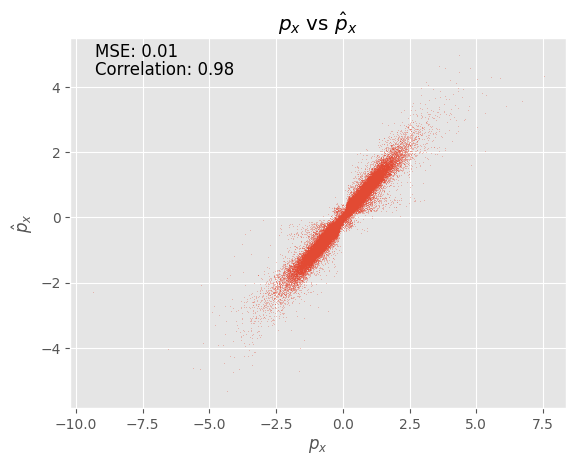

In [60]:
correlation_coefficient = np.corrcoef(c[:, 0], p[:, 0])[0, 1]
mse = np.mean((c[:, 0] - p[:, 0])**2)
plt.title('$p_x$ vs $\\hat{p}_x$')
plt.scatter(c[:, 0], p[:, 0], s=0.01)
plt.annotate(f'MSE: {mse:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.annotate(f'Correlation: {correlation_coefficient:.2f}', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=12)
plt.xlabel('$p_x$')
plt.ylabel('$\\hat{p}_x$')

Text(0, 0.5, '$\\hat{p}_y$')

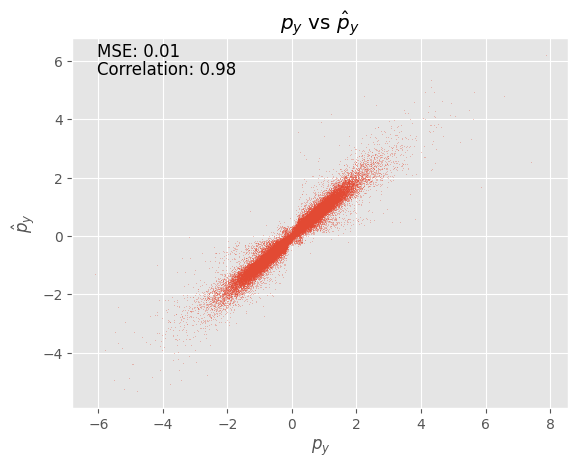

In [61]:
correlation_coefficient = np.corrcoef(c[:, 1], p[:, 1])[0, 1]
mse = np.mean((c[:, 1] - p[:, 1])**2)
plt.title('$p_y$ vs $\\hat{p}_y$')
plt.scatter(c[:, 1], p[:, 1], s=0.01)
plt.annotate(f'MSE: {mse:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.annotate(f'Correlation: {correlation_coefficient:.2f}', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=12)
plt.xlabel('$p_y$')
plt.ylabel('$\\hat{p}_y$')

Text(0, 0.5, '$\\hat{p}_z$')

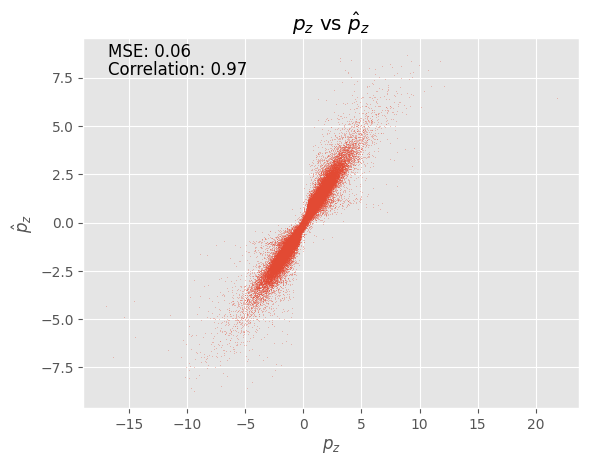

In [62]:
correlation_coefficient = np.corrcoef(c[:, 2], p[:, 2])[0, 1]
mse = np.mean((c[:, 2] - p[:, 2])**2)
plt.title('$p_z$ vs $\\hat{p}_z$')
plt.scatter(c[:, 2], p[:, 2], s=0.01)
plt.annotate(f'MSE: {mse:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
plt.annotate(f'Correlation: {correlation_coefficient:.2f}', xy=(0.05, 0.90), xycoords='axes fraction', fontsize=12)
plt.xlabel('$p_z$')
plt.ylabel('$\\hat{p}_z$')

Text(0, 0.5, '$\\hat{E}$')

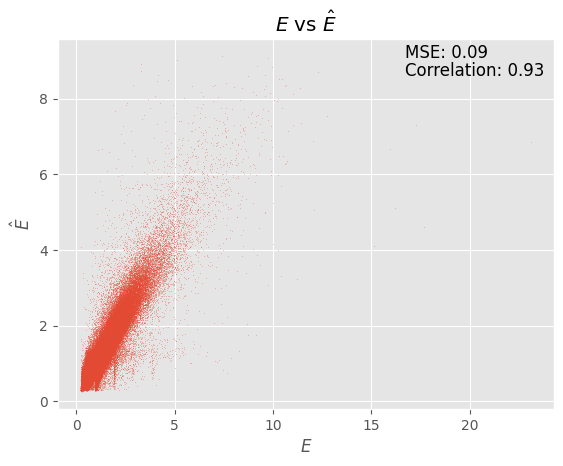

In [63]:
correlation_coefficient = np.corrcoef(c[:, 3], p[:, 3])[0, 1]
mse = np.mean((c[:, 3] - p[:, 3])**2)
plt.title('$E$ vs $\\hat{E}$')
plt.scatter(c[:, 3], p[:, 3], s=0.01)
plt.annotate(f'MSE: {mse:.2f}', xy=(0.7, 0.95), xycoords='axes fraction', fontsize=12)
plt.annotate(f'Correlation: {correlation_coefficient:.2f}', xy=(0.7, 0.90), xycoords='axes fraction', fontsize=12)
plt.xlabel('$E$')
plt.ylabel('$\\hat{E}$')

In [67]:
np.mean(c[:, 3]) - np.mean(p[:, 3])

0.018972874

In [13]:
p = np.stack(preds, axis=0)

In [13]:
len(correct)

500000

In [1]:
correct.shape

NameError: name 'correct' is not defined

In [14]:
preds_prob = np.array(preds_prob)
preds = np.array(preds)
correct = np.array(correct)

In [15]:
accs_gt = np.sum(preds == correct, axis=-1)/correct.shape[0]
accs_gt

0.86086

In [40]:
efficiency_purity(correct, preds_prob, signal_mix=0.01)

(0.8832684824902723, 0.04531842683170294, 0.8127422954928143)

In [49]:
efficiency_purity(correct, preds_prob, signal_mix=0.01)

(0.8910505836575876, 0.045699461185392136, 0.8127422954928143)

In [16]:
efficiencies, purities, brrs = efficiency_purity_2(correct, preds_prob, signal_mix=0.001)

np.sum(c)/c.shape[0]=0.0009979362677981934


In [19]:
efficiencies_1, purities_1, brrs_1 = efficiency_purity_2(correct, preds_prob, signal_mix=0.01)

np.sum(c)/c.shape[0]=0.009996281557315443


In [22]:
i = np.argmin(np.abs(brrs-0.99))

In [23]:
efficiencies[i]*100, purities[i]*100

(23.200000000000003, 2.266510355607659)

In [24]:
i = np.argmin(np.abs(brrs_1-0.99))

In [25]:
efficiencies_1[i]*100, purities_1[i]*100

(19.35100910170162, 16.354515050167223)

Text(0.5, 1.0, 'Ground-Truth Track Efficiency/Purity Plot')

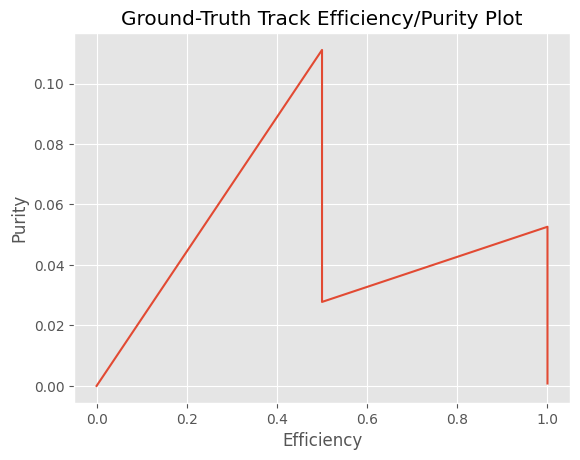

In [29]:
plt.style.use('ggplot')
plt.plot(efficiencies, purities)
plt.xlabel('Efficiency')
plt.ylabel('Purity')
plt.title('Ground-Truth Track Efficiency/Purity Plot')

Text(0.5, 1.0, 'Ground-Truth Track Efficiency/BRR Plot')

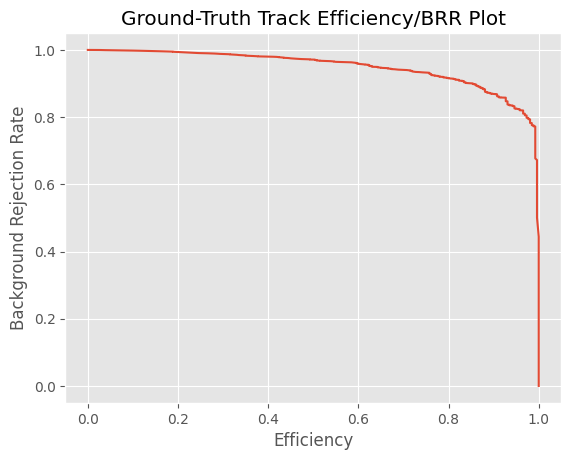

In [112]:
plt.style.use('ggplot')
plt.plot(efficiencies, brrs)
plt.xlabel('Efficiency')
plt.ylabel('Background Rejection Rate')
plt.title('Ground-Truth Track Efficiency/BRR Plot')

In [60]:
purities

array([0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615, 0.0615,
       0.0615, 0.0615, 0.0615, 0.0615])

In [26]:
accs_pred_phi, accs_gt_phi

(array([0.86396484, 0.8625    , 0.86191406, 0.86191406, 0.85991211,
        0.86025391, 0.85908203, 0.85795898, 0.85771484, 0.85859375,
        0.85810547, 0.8574707 , 0.85649414, 0.85615234, 0.85541992,
        0.85595703, 0.85668945, 0.85678711, 0.85791016, 0.85888672,
        0.85869141, 0.85932617, 0.85927734, 0.85932617, 0.85854492,
        0.86015625, 0.85932617, 0.859375  , 0.85874023, 0.85849609,
        0.85927734, 0.85991211, 0.85961914, 0.86005859, 0.86015625,
        0.8609375 , 0.86079102, 0.86201172, 0.86254883, 0.86396484]),
 array([0.90356445, 0.90332031, 0.9034668 , 0.9019043 , 0.90019531,
        0.89829102, 0.89462891, 0.88847656, 0.878125  , 0.86557617,
        0.86103516, 0.87241211, 0.88481445, 0.89287109, 0.89785156,
        0.90019531, 0.90219727, 0.90219727, 0.9027832 , 0.90234375,
        0.9027832 , 0.9027832 , 0.90288086, 0.90239258, 0.90117187,
        0.89916992, 0.89375   , 0.88457031, 0.87290039, 0.86347656,
        0.86801758, 0.88217773, 0.89287109, 0.

In [ ]:
plt.plot(np.linspace(0, 2*np.pi, 40), accs_gt)
x_ticks = np.arange(0, (2 + 1/2)*np.pi, np.pi/2)
print(x_ticks)
ax = plt.gca()  # Get the current axis
ax.set_xticks(x_ticks)
ax.set_xticklabels(["0", "$\\frac{π}{2}$", "π", "$\\frac{3π}{2}$", "2π"])
plt.xlabel('Rotation Angle Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Rotation on Accuracy (GT Tracks)")

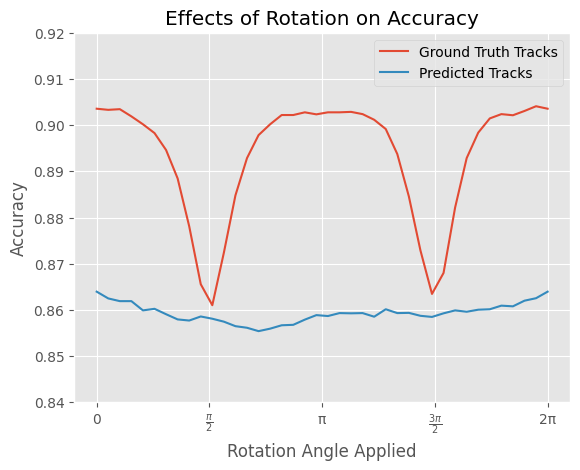

In [43]:
plt.style.use('ggplot')

plt.plot(np.linspace(0, 2*np.pi, 40), accs_gt_phi, label='Ground Truth Tracks')
plt.plot(np.linspace(0, 2*np.pi, 40), accs_pred_phi, label='Predicted Tracks')
x_ticks = np.arange(0, (2 + 1/2)*np.pi, np.pi/2)
ax = plt.gca()  # Get the current axis
ax.set_xticks(x_ticks)
ax.set_xticklabels(["0", "$\\frac{π}{2}$", "π", "$\\frac{3π}{2}$", "2π"])
plt.xlabel('Rotation Angle Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Rotation on Accuracy")
plt.ylim(0.84, 0.92)
plt.legend()

In [11]:
N_BATCHES = 1
all_preds = []
all_preds_prob = []
all_correct = []
val_data.dataset.dataset.phi = 0
for z in np.linspace(-20, 20, 10):
    preds = []
    preds_prob = []
    correct = []
    val_data.dataset.dataset.z = z
    for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
        mask = torch.zeros(batch.track_vector.shape[:-1])
        for i, n in enumerate(batch.n_tracks):
            mask[i, :n] = 1
            

        mask = mask.to(DEVICE)
        track_vector = batch.track_vector.to(DEVICE)
        n_batches, n_tracks = track_vector.shape[:2]
        hits = track_vector[:, :, :15].reshape(n_batches, n_tracks, 5, 3)
        
        
        is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
        trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

        mask_logits = model(track_vector, mask)
        pred = mask_logits.max(dim=1)[1]
        preds.extend(pred.cpu().data.numpy())
        preds_prob.extend(nn.Softmax(dim=1)(mask_logits)[:, 1].detach().cpu().numpy().flatten())
        correct.extend(trigger.detach().cpu().numpy().flatten())
    all_correct.append(correct)
    all_preds.append(preds)
    all_preds_prob.append(preds_prob)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Effects of Z Translation on Accuracy (GT Tracks)')

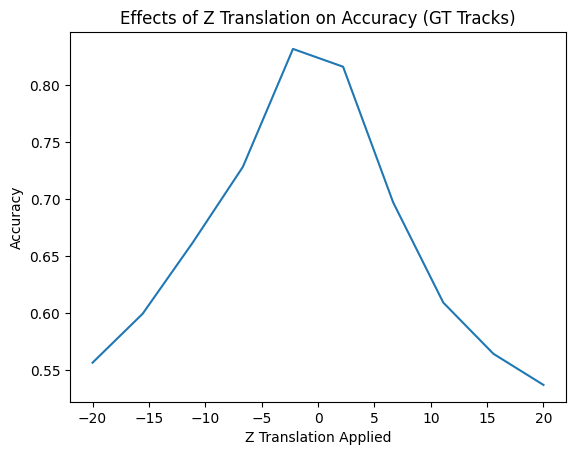

In [14]:
plt.plot(np.linspace(-20, 20, 10), accs_pred_z)
plt.xlabel('Z Translation Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Z Translation on Accuracy (GT Tracks)")

In [13]:
all_preds = np.array(all_preds)
all_correct = np.array(all_correct)
accs_pred_z = np.sum(all_preds == all_correct, axis=-1)/all_correct.shape[1]

Text(0.5, 1.0, 'Effects of Z Translation on Accuracy (GT Tracks)')

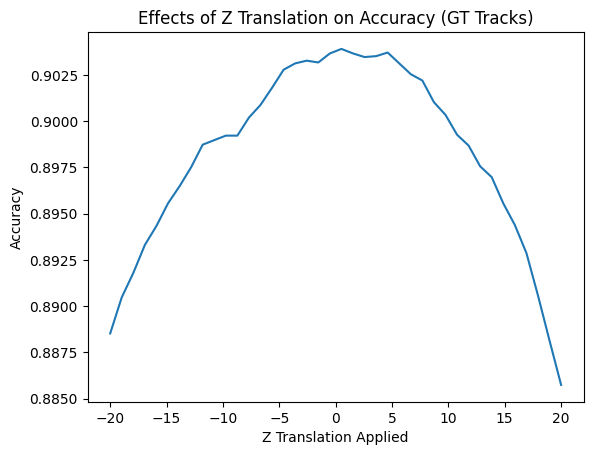

In [37]:
plt.plot(np.linspace(-20, 20, 40), accs_gt)
plt.xlabel('Z Translation Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Z Translation on Accuracy (GT Tracks)")

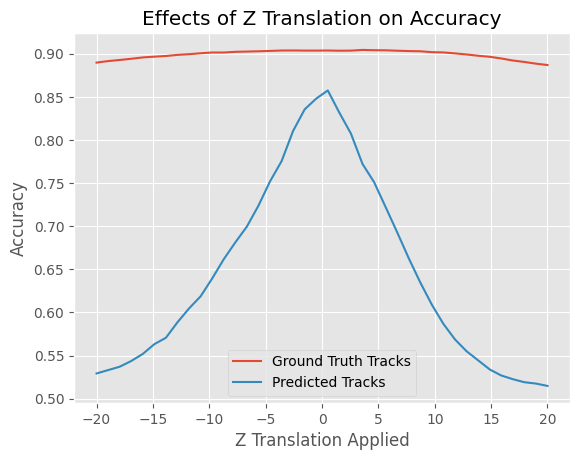

In [52]:
plt.style.use('ggplot')
plt.plot(np.linspace(-20, 20, 40), accs_gt_z, label='Ground Truth Tracks')
plt.plot(np.linspace(-20, 20, 40), accs_pred_z, label='Predicted Tracks')
plt.xlabel('Z Translation Applied')
plt.ylabel('Accuracy')
plt.title("Effects of Z Translation on Accuracy")
plt.legend()

In [34]:
accs_gt_z, accs_pred_z

(array([0.88974609, 0.89150391, 0.89277344, 0.89418945, 0.89575195,
        0.89663086, 0.89741211, 0.89868164, 0.89951172, 0.90058594,
        0.90146484, 0.90141602, 0.90224609, 0.90253906, 0.90288086,
        0.90327148, 0.90375977, 0.90380859, 0.90366211, 0.90366211,
        0.90375977, 0.90351563, 0.90361328, 0.90444336, 0.90410156,
        0.90400391, 0.90351563, 0.903125  , 0.90288086, 0.90185547,
        0.90151367, 0.90043945, 0.89916992, 0.89770508, 0.89648438,
        0.89453125, 0.8921875 , 0.89047852, 0.88852539, 0.88691406]),
 array([0.53339844, 0.53847656, 0.5449707 , 0.55209961, 0.56079102,
        0.56977539, 0.58139648, 0.59355469, 0.60717773, 0.62148437,
        0.63842773, 0.65874023, 0.67739258, 0.70102539, 0.72509766,
        0.7527832 , 0.7824707 , 0.80791016, 0.83466797, 0.85678711,
        0.8609375 , 0.8418457 , 0.81318359, 0.78413086, 0.75449219,
        0.72202148, 0.69140625, 0.6625    , 0.63354492, 0.60693359,
        0.58305664, 0.56455078, 0.55170898, 0.

# Collect Statistics on Z-Distribution

In [47]:
N_BATCHES = 400
zs = []
val_data.dataset.dataset.phi = 0
val_data.dataset.dataset.z = 0


for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
    mask = torch.zeros(batch.track_vector.shape[:-1])
    for i, n in enumerate(batch.n_tracks):
        mask[i, :n] = 1

    mask = mask.to(DEVICE)
    track_vector = batch.track_vector.to(DEVICE)
    track_vector = track_vector * mask.unsqueeze(-1)
    n_batches, n_tracks = track_vector.shape[:2]
    hits = track_vector[:, :, :15].reshape(n_batches, n_tracks, 5, 3)
    good_hits = torch.any(hits != 0, dim=-1)
    zs.extend(hits[..., -1][good_hits].cpu().detach().numpy())

  0%|          | 0/400 [00:00<?, ?it/s]

In [39]:
gt_zs = np.array(zs)

In [48]:
pred_zs = np.array(zs)

Text(0.5, 1.0, 'Distribution of Z-Coordinate')

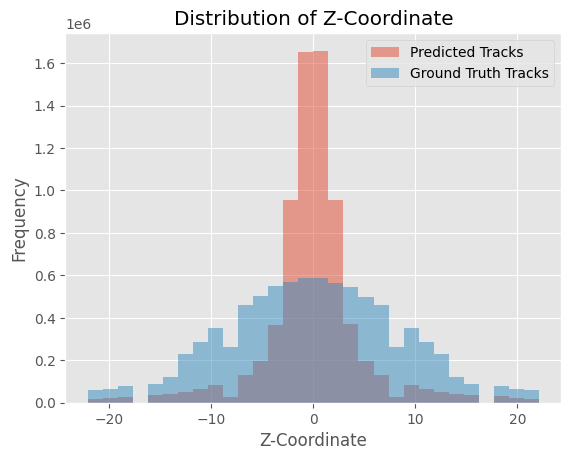

In [54]:
plt.style.use('ggplot')
plt.hist(pred_zs, bins=30, alpha=0.5, label='Predicted Tracks')
plt.hist(gt_zs, bins=30, alpha=0.5, label='Ground Truth Tracks')
plt.xlabel('Z-Coordinate')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Z-Coordinate')

In [49]:
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)
    Compute and plot a histogram.
    
    This method uses `numpy.histogram` to bin the data in *x* and count the
    number of values in each bin, then draws the distribution either as a
    `.BarContainer` or `.Polygon`. The *bins*, *range*, *density*, and
    *weights* parameters are forwarded to `numpy.histogram`.
    
    If the data has already been binned and counted, use `~.bar` or
    `~.stairs` to plot the distribution::
    
        counts, bins = np.histogram(x)
        plt.stairs(counts, bins)
    
    Alternatively, plot pre-computed bins and counts using ``hist()`` by
    treating each bin as a single point with a weight equal to its count::
    
        plt.hist(bins[:-1], bins, weights=coun

# Track Dropping

In [67]:
N_BATCHES = 80
# No dropping
all_preds = []
all_preds_prob = []
# Drop TT
tt_preds = []
tt_preds_prob = []
# Drop NT
nt_preds = []
nt_preds_prob = []

correct = []
val_data.dataset.dataset.phi = 0
val_data.dataset.dataset.z = 0

for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
    mask = torch.zeros(batch.track_vector.shape[:-1])
    nt_mask = torch.zeros(batch.track_vector.shape[:-1])
    for i, n in enumerate(batch.n_tracks):
        mask[i, :n] = 1
        nt_mask[i, :n] = 1
        n_trigger_tracks = torch.sum(batch.is_trigger_track[i].to(torch.bool))
        non_trigger_tracks = torch.where(~batch.is_trigger_track[i, :n].to(torch.bool))[0].numpy().tolist()
        #print(f'{non_trigger_tracks=}')
        random.shuffle(non_trigger_tracks)
        #print(f'{non_trigger_tracks=}')
        # We are randomly dropping the same amount of non-trigger tracks as of trigger tracks
        for j in non_trigger_tracks[:n_trigger_tracks]:
            #print(f'Setting {j} to 0')
            nt_mask[i, j] = 0
        #if n_trigger_tracks != 0:
           # print(f'{n_trigger_tracks=}\n{mask[i, :n]=}\n{nt_mask[i, :n]=}')
        

    mask = mask.to(DEVICE)
    nt_mask = nt_mask.to(DEVICE)
    track_vector = batch.track_vector.to(DEVICE)

    is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
    trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

    mask_logits = model(track_vector, mask)
    pred = mask_logits.max(dim=1)[1]
    all_preds.extend(pred[trigger.flatten()].cpu().numpy())
    all_preds_prob.extend(nn.Softmax(dim=1)(mask_logits[trigger.flatten()])[:, 1].detach().cpu().numpy().flatten())
    # Drop the trigger-tracks
    tt_mask = mask * ~is_trigger_track
    mask_logits = model(track_vector, tt_mask)
    tt_preds.extend(pred[trigger.flatten()].cpu().numpy())
    tt_preds_prob.extend(nn.Softmax(dim=1)(mask_logits[trigger.flatten()])[:, 1].detach().cpu().numpy().flatten())

    mask_logits = model(track_vector, nt_mask)
    nt_preds.extend(pred[trigger.flatten()].cpu().numpy())
    nt_preds_prob.extend(nn.Softmax(dim=1)(mask_logits[trigger.flatten()])[:, 1].detach().cpu().numpy().flatten())

    
    correct.extend(trigger.detach().cpu().numpy().flatten())



  0%|          | 0/80 [00:00<?, ?it/s]

In [58]:
all_pred = np.array(all_preds_prob)
all_pred_tt = np.array(tt_preds_prob)
all_pred_nt = np.array(nt_preds_prob)

In [68]:
all_gt = np.array(all_preds_prob)
all_gt_tt = np.array(tt_preds_prob)
all_gt_nt = np.array(nt_preds_prob)

In [59]:
len(all_pred)

20534

Text(0.5, 1.0, 'Effect of Track Dropping on Trigger Probability Distribution')

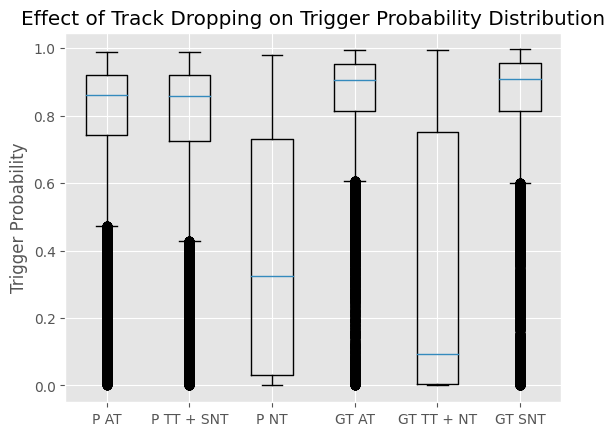

In [73]:
plt.style.use('ggplot')
plt.boxplot([all_pred, all_pred_nt, all_pred_tt, all_gt, all_gt_tt, all_gt_nt])
plt.xticks([1, 2, 3, 4, 5, 6], ['P AT', 'P TT + SNT', 'P NT', 'GT AT', 'GT TT + NT', 'GT SNT'])  # Adjust or add more labels based on your datasets
plt.ylabel('Trigger Probability')
plt.title('Effect of Track Dropping on Trigger Probability Distribution')

# Hit-Dropping

In [76]:
N_BATCHES = 80
# No dropping
pred_probs = [list() for i in range(5)]


val_data.dataset.dataset.phi = 0
val_data.dataset.dataset.z = 0

for layer_drop in range(5):
    for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
        mask = torch.zeros(batch.track_vector.shape[:-1])
        for i, n in enumerate(batch.n_tracks):
            mask[i, :n] = 1


        mask = mask.to(DEVICE)
        track_vector = batch.track_vector.to(DEVICE)
        n_batches, n_tracks = track_vector.shape[:2]
        hits = track_vector[..., :15].reshape(n_batches, n_tracks, 5, 3)
        hits[:, :, layer_drop, :] = 0
        track_vector[..., :15] = hits.reshape(n_batches, n_tracks, 15)

        is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
        trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

        mask_logits = model(track_vector, mask)
        pred = mask_logits.max(dim=1)[1]
        pred_probs[layer_drop].extend(nn.Softmax(dim=1)(mask_logits[trigger.flatten()])[:, 1].detach().cpu().numpy().flatten())
    


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0e34ad75b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0e244fa500>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0e441577c0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0e244f9570>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0e244f9210>,
 'means': []}

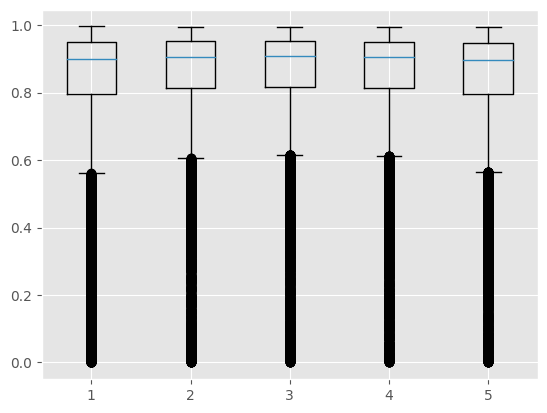

In [77]:
plt.boxplot(pred_probs)

# Noise Std

In [27]:
N_BATCHES = 40
all_preds = []
all_preds_prob = []
all_correct = []
val_data.dataset.dataset.phi = val_data.dataset.dataset.z = 0
noise_stds = np.linspace(-6, -1, 30)
#noise_stds = [-np.inf]
for noise_std in noise_stds:
    val_data.dataset.dataset.noise_std = 10**noise_std
    preds = []
    preds_prob = []
    correct = []
    for batch in tqdm(islice(val_data, 0, N_BATCHES), total=N_BATCHES):
        mask = torch.zeros(batch.track_vector.shape[:-1])
        for i, n in enumerate(batch.n_tracks):
            mask[i, :n] = 1
            

        mask = mask.to(DEVICE)
        track_vector = batch.track_vector.to(DEVICE)
        n_batches, n_tracks = track_vector.shape[:2]
        hits = track_vector[:, :, :15].reshape(n_batches, n_tracks, 5, 3)
        
        
        is_trigger_track = batch.is_trigger_track.to(DEVICE, torch.bool)
        trigger = (batch.trigger.to(DEVICE) == 1).unsqueeze(-1)

        mask_logits = model(track_vector, mask)
        pred = mask_logits.max(dim=1)[1]
        preds.extend(pred.cpu().data.numpy())
        preds_prob.extend(nn.Softmax(dim=1)(mask_logits)[:, 1].detach().cpu().numpy().flatten())
        correct.extend(trigger.detach().cpu().numpy().flatten())
    all_correct.append(correct)
    all_preds.append(preds)
    all_preds_prob.append(preds_prob)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [28]:
all_preds = np.array(all_preds)
all_correct = np.array(all_correct)
accs_gt_noise = np.sum(all_preds == all_correct, axis=-1)/all_correct.shape[1]

In [22]:
accs_gt_noise

array([0.86171875, 0.86171875, 0.86201172, 0.86123047, 0.8609375 ,
       0.86162109, 0.86054688, 0.86123047, 0.86147461, 0.85913086,
       0.85800781, 0.8550293 , 0.85263672, 0.84926758, 0.84204102,
       0.83647461, 0.82114258, 0.80473633, 0.78583984, 0.76347656,
       0.7418457 , 0.71289062, 0.68833008, 0.66591797, 0.65375977,
       0.63686523, 0.63540039, 0.63378906, 0.63691406, 0.64228516])

In [15]:
accs_pred_noise

array([0.86171875, 0.86171875, 0.86201172, 0.86123047, 0.8609375 ,
       0.86162109, 0.86054688, 0.86123047, 0.86147461, 0.85913086,
       0.85800781, 0.8550293 , 0.85263672, 0.84926758, 0.84204102,
       0.83647461, 0.82114258, 0.80473633, 0.78583984, 0.76347656,
       0.7418457 , 0.71289062, 0.68833008, 0.66591797, 0.65375977,
       0.63686523, 0.63540039, 0.63378906, 0.63691406, 0.64228516])

In [23]:
accs_gt_noise

array([0.90541992, 0.90537109, 0.90537109, 0.90541992, 0.90532227,
       0.90522461, 0.90512695, 0.90522461, 0.90493164, 0.90546875,
       0.90551758, 0.90463867, 0.90537109, 0.90395508, 0.90332031,
       0.90107422, 0.89135742, 0.87055664, 0.81494141, 0.715625  ,
       0.61269531, 0.54052734, 0.51552734, 0.50473633, 0.50180664,
       0.50058594, 0.49990234, 0.49985352, 0.49975586, 0.49951172])

In [12]:
accs_gt_noise, accs_pred_noise

NameError: name 'accs_gt_noise' is not defined

In [20]:
accs_gt_noise

array([0.86621094, 0.87011719, 0.84667969, 0.72949219, 0.66308594,
       0.64355469])

In [18]:
accs_pred_noise

array([0.86171875, 0.86171875, 0.86201172, 0.86123047, 0.8609375 ,
       0.86162109, 0.86054688, 0.86123047, 0.86147461, 0.85913086,
       0.85800781, 0.8550293 , 0.85263672, 0.84926758, 0.84204102,
       0.83647461, 0.82114258, 0.80473633, 0.78583984, 0.76347656,
       0.7418457 , 0.71289062, 0.68833008, 0.66591797, 0.65375977,
       0.63686523, 0.63540039, 0.63378906, 0.63691406, 0.64228516])

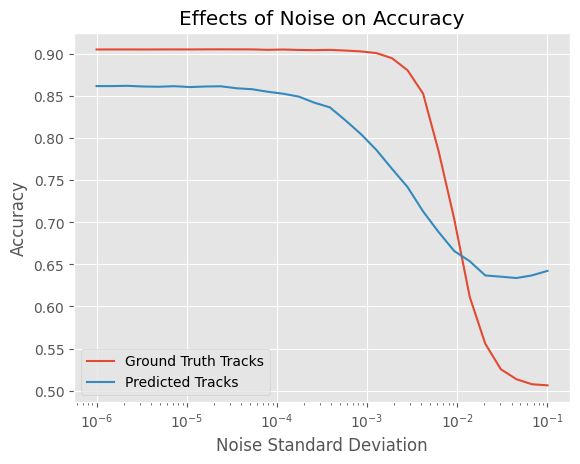

In [29]:
plt.style.use('ggplot')
plt.plot(10**noise_stds, accs_gt_noise, label='Ground Truth Tracks')
plt.plot(10**noise_stds, accs_pred_noise, label='Predicted Tracks')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.title("Effects of Noise on Accuracy")
plt.legend()